# Import libraries

In [1]:
#Import libaries
import random
import numpy  as np
import matplotlib.pyplot as plt
import os
import scienceplots

#Import self-written functions
from HD_DataLoader import *
import GA_feature_extraction as fe


# Load in the data

In [2]:
# generate database
folder_path = os.path.join(os.getcwd(), 'HD_data') 
HD_class = HD(data_path = folder_path)
HD_database = HD_class.generate_database()

---------------------------------------------------------
Generating database for HD's


In [3]:
##### load microphone data
anom_mic = []
norm_mic = []

keys_mic = ['Data']
for test in HD_database:
    if HD_database[test]['attributes']['HD_status'] == 1:  # it is faulty HD
        mic = {key: HD_database[test]['Microphone'][key] for key in keys_mic}
        anom_mic.append([mic[key] for key in keys_mic])
    elif HD_database[test]['attributes']['HD_status'] == 0:  # it is working HD
        mic = {key: HD_database[test]['Microphone'][key] for key in keys_mic}
        norm_mic.append([mic[key] for key in keys_mic])

anom_mic = np.array(anom_mic)
norm_mic = np.array(norm_mic)
mic_data = np.concatenate((norm_mic, anom_mic), axis=0)

# only keep the left stereo, since the difference of left and right stereos is very small:
# shape:[n_files*1*n_samples (fs * secs)*2]-> shape:[n_files*1*n_samples (fs * secs)]
mic_data = mic_data[:, :, :, 0]

# eliminate dimensions of only one element
# shape:[n_files*1*n_samples (fs * secs)]-> shape:[n_files*n_samples (fs * secs)]
mic_data = np.squeeze(mic_data)



###### load current data
anom_current = []
norm_current = []

keys_current = ['i_motor_LP']
for test in HD_database:
    if HD_database[test]['attributes']['HD_status'] == 1:  # it is faulty HD
        current = {key: HD_database[test]['dSpace'][key] for key in keys_current}
        anom_current.append([current[key] for key in keys_current])
    elif HD_database[test]['attributes']['HD_status'] == 0:  # it is working HD
        current = {key: HD_database[test]['dSpace'][key] for key in keys_current}
        norm_current.append([current[key] for key in keys_current])

#since the lengths of current tests were not equal, crop the test data so that concatenation could be achieved
def find_min_len(current_data):
    """ 
    find the minimum length of the elements in one two-dimensional current data list
    """
    min_len = current_data[0][0].shape
    for i in range (len(current_data) - 1):
        if current_data[i][0].shape > current_data[i+1][0].shape:
            min_len = current_data[i+1][0].shape
    min_len = int(min_len[0])
    return min_len

# find min length of both anom and norm current data
anom_min_len = find_min_len(anom_current)
norm_min_len = find_min_len(norm_current)
current_min_len = min(anom_min_len, norm_min_len)

# resize all both the anom and norm current data into the min length and concatenate them
for i in range (len(anom_current)):
    anom_current[i][0] = np.resize(anom_current[i][0], current_min_len)
for i in range (len(norm_current)):
    norm_current[i][0] = np.resize(norm_current[i][0], current_min_len)
anom_current = np.array(anom_current)
norm_current = np.array(norm_current)
current_data = np.squeeze(np.concatenate((norm_current, anom_current), axis=0))

# Extract features

In [4]:
# adjust the x's in the below code to change the lengths of time windows during feature extraction

mic_time_feats = fe.extract_time_features(data = mic_data, x = 44100)   # used fs as x
mic_fft_feats = fe.extract_fft_features(data=mic_data, x = 44100)   # used fs as x
# using x = (current_min_len/60) could produce the same n_time_windows as mic data
current_time_feats = fe.extract_time_features(data=current_data, x = int(current_min_len/60))  


# normalize features (due to the scale difference between different features)
def normlize_feats(feature_map):
    # normalize feature map (use min-max normalizaton: (x-min)/(max-min))
    for i in range(feature_map.shape[1]):
        colomn_min = np.min(feature_map[:, i])
        colomn_max = np.max(feature_map[:, i])
        for j in range(feature_map.shape[0]):
            feature_map[j, i] = (feature_map[j, i] - colomn_min)/(colomn_max - colomn_min)
    return feature_map

mic_time_feats_norm = normlize_feats(mic_time_feats)
mic_fft_feats_norm = normlize_feats(mic_fft_feats)
current_time_feats_norm = normlize_feats(current_time_feats)
feature_map_norm = np.hstack((mic_time_feats_norm, mic_fft_feats_norm, current_time_feats_norm))


# Perform GA

In [5]:
# define the fitness function
def  calculate_fitness(individual , X):
    # Convert  binary  string  to  boolean  mask
    mask = np.array(list(individual), dtype=bool)
    # Apply  mask to  dataset
    X_masked = X[:, mask]
    # Calculate  variance  of each  feature
    variances = np.var(X_masked , axis =0)
    # Calculate  fitness  as the  sum of  variances
    fitness = np.sum(variances)
    
    return  fitness


# define the genetic algorithm
def genetic_algorithm(data, n_goal_features, population_size, num_genes, calculate_fitness, mutation_rate, elitism_rate, num_generations):
    """ 
    Implement genetic algorithm which derives features of low dimentionality from feature of high dimensionality. (dimensionality of features reduction)

    Params:
    data: input data on which genetic algorithm will be implemented; size: n_samples * n_all_features (high dimension)
    n_goal_features: target number of features (low dimension)
    population_size: population size initialization: 2 to the n_feature (high) th 
    num_genes: = n_all_features (high dimension)
    calculate_fitness: fitness score function
    mutation_rate: mutation rate, between (0, 1) 
    elitism_rate: elitism rate, between (0, 1)
    num_generations: number of generations
    

    return: a feature map with the number of selected features of n_goal_features
    """

    # initialize the population
    population = []
    for i in range(population_size):
        individual = [0] * num_genes  # initialize all genes to zeros
        for j in random.sample(range(num_genes), n_goal_features):  # choose genes locations randomly
            individual[j] = 1  # set the chosen genes locations to one
        population.append(individual)

    # run the evolution loop for num_generations
    for generation in range(num_generations):
        # evaluate the fitness of each individual in the population
        fitness_values = [calculate_fitness(individual, data) for individual in population]

        # select the fittest individuals for the next generation
        num_elites = int(elitism_rate * population_size)
        elites = sorted(range(len(population)), key=lambda i: fitness_values[i], reverse=True)[:num_elites]
        next_generation = [population[i] for i in elites]

        # breed new individuals to fill the rest of the next generation
        while len(next_generation) < population_size:
            """ parent1, parent2 = random.choices(population, weights=fitness_values, k=2)
            child = []
            # to ensure number of genes chosen will not exceed n_goal_features, we will select a crossover point, then copy the genes before the location from parent1, and copy the rest
            #of genes after the location from parent2
            crossover_point = random.randint(1, num_genes-1)   # choose a crossover point
            # perform crossover
            child = parent1[:crossover_point] + parent2[crossover_point:] """
            parent1, parent2 = random.choices(population, weights=fitness_values, k=2)
            child = [parent1[i] if random.random() < 0.5 else parent2[i] for i in range(num_genes)]
            # if the number of genes chosen exceeds n_goal_features, then we will randomly set genes to zero until the number is equal to n_goal_features
            while sum(child) >= n_goal_features:
                random_index = random.randint(0, len(child) - 1)
                child[random_index] = 0

            # in mutation operation, in order to ensure number of genes chosen will not exceed n_goal_features, we will check if the number of genes chosen already equals to n_goal_features,
            # if so, we will not proceed mutation operation. If not, we will continue to choose one genes to make negation
            if random.random() < mutation_rate:
                gene_to_mutate = random.randint(0, num_genes-1)
                if sum(child) < n_goal_features:
                    child[gene_to_mutate] = 1 - child[gene_to_mutate]
            next_generation.append(child)
            

        # replace the old population with the new generation
        population = next_generation

        print("Generation {} finished".format(generation+1))

    genes_chosen = np.array(max(population, key=lambda individual: calculate_fitness(individual, data)))
    # indicate the locations of chosen genes
    genes_chosen_loc = np.where(genes_chosen == 1)[0]
    print("locations of chosen genes (starts from zero):", genes_chosen_loc)
    # Convert  binary  array  to  boolean  mask
    features_mask= genes_chosen.astype(bool)
    # Apply  mask to  dataset
    features_chosen = data[:, features_mask]

    # return the features of low dimensionatlity
    return features_chosen

In [6]:
# choose featuers to be put into genetic_algorithm
# change the columns of feature_map_norm to choose different features: [:15]->Mic(time); [15:20]->Mic(freq); [20:]->Cur(time)
feature_map_chosen = feature_map_norm[:, :15]

# n_goal_features, num_genes need to be adjusted; population_size, mutation_rate, elitism_rate, num_generations could be tuned.
# After trials, population_size should increase with num_genes increasing, while other parameters are less likely to be tuned
n_goal_features = 2
data = feature_map_chosen
# if want to cover all combinations of features, then set 2 to the n_genes th, note that the running tiem would be very long 
population_size =  10000  
num_genes = 15  
mutation_rate=0.01
elitism_rate=0.1
num_generations= 5

features_chosen = genetic_algorithm(data, n_goal_features, population_size, num_genes, calculate_fitness, mutation_rate, 
                                    elitism_rate, num_generations)

Generation 1 finished
Generation 2 finished
Generation 3 finished
Generation 4 finished
Generation 5 finished
locations of chosen genes (starts from zero): [2 4]


<Figure size 640x480 with 0 Axes>

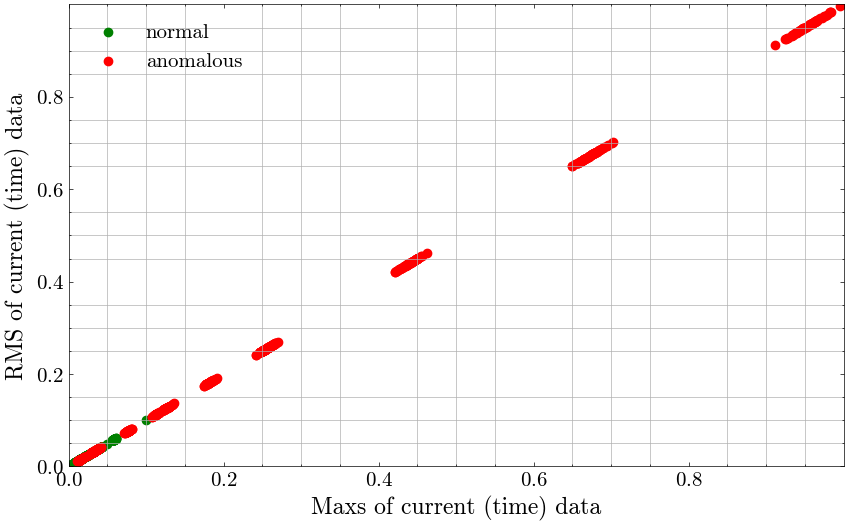

In [7]:
# draw scatter plot with the features found
def features_plot(features, n_norm):
    plt.figure()

    x_norm = features[:n_norm, 0]
    y_norm = features[:n_norm, 1]
    x_anom = features[n_norm:, 0]
    y_anom = features[n_norm:, 1]

   # Adjust the plotsettings in this code:
    fontsize = 20
    ticksize = 15
    plt.style.use('science')
    # set the visiblity to bright
    params = {  "xtick.color" : "black",
                "ytick.color" : "black",
                "axes.labelsize": ticksize,
                "axes.labelcolor": "black",
                "font.size": fontsize,
                "text.usetex": False} 
    plt.rcParams.update(params)

    plt.figure(figsize = (10, 6))

    plt.scatter(x_norm, y_norm, c='g', label='normal')
    plt.scatter(x_anom, y_anom, c='r', label='anomalous')

    plt.xlabel('Maxs of current (time) data', fontsize = 17)
    plt.ylabel('RMS of current (time) data', fontsize = 17)
    plt.xlim((0, 1))
    plt.ylim((0, 1))
    plt.xticks(np.arange(0, 1, 0.2), fontsize = ticksize)
    plt.yticks(np.arange(0, 1, 0.2), fontsize = ticksize)
    plt.legend(fontsize = ticksize)
    plt.grid(True, which='minor')   # add grid

    file_path = os.path.join(os.getcwd(), 'Figures','GA_exam.eps') 
    plt.savefig(file_path, format='eps')
    
    plt.show()

    

features = features_chosen
# note that number of normal test files and anomalous test files should be the same to run this line. Or, adjust n_norm and run.
features_plot(features, n_norm = int(features_chosen.shape[0]/2))